In [55]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import lightning as L
from tqdm import tqdm
from torchvision.models import vit_b_16 # pretrained model
from torchsummary import summary
import kagglehub

# Download data and load into pandas dataframe

In [ ]:
# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

# directory paths
train_dir = os.path.join(path, "Training/")
test_dir = os.path.join(path, "Testing/")

# load data to dataframe with file names and labels
def load_to_df(file_path):
	file_names = []
	labels = []
	folders = os.listdir(file_path)
	for folder in folders:
		folder_path = file_path + folder
		files = os.listdir(file_path + folder)
		for file in files:
			file_names.append(file)
			labels.append(folder)

	df = pd.DataFrame({"file_name": file_names, "label": labels})
	return df

# load data to dataframes
train_df = load_to_df(train_dir)
test_df = load_to_df(test_dir)

print(f'Length of train_df: {len(train_df)}')
print(f'Length of test_df: {len(test_df)}')

Length of train_df: 5712
Length of test_df: 1311


# Dataset creation

In [59]:
# setup for the dataset
class BrainTumorDataset(Dataset):
	def __init__(self, df, file_path, transform=None):
		self.df = df
		self.file_path = file_path
		self.transform = transform

		# Create mappings between class names and indices
		self.unique_labels = df.iloc[:, 1].unique()
		self.class_to_idx = {label: idx for idx, label in enumerate(self.unique_labels)}
		self.idx_to_class = {idx: label for label, idx in self.class_to_idx.items()}

	def __len__(self):
		return len(self.df)

	def __getitem__(self, idx):
		file_name = self.df.iloc[idx, 0]
		label = self.df.iloc[idx, 1]
		img = Image.open(self.file_path + label + "/" + file_name)
				
		if self.transform:
			img = self.transform(img)

		label = self.class_to_idx[label] if isinstance(label, str) else int(label)

		return img, label

In [60]:
# Function to show a grid of images from a single batch
def show_image_grid(images, labels, rows=4, cols=8):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()
    
    # Display each image in the batch
    for i in range(len(images)):
        img = images[i].numpy().transpose((1, 2, 0))  # Convert to HWC format for plotting
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis("off")  # Hide axes

    # Hide any extra subplots in case there are fewer images than grid cells
    for j in range(len(images), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Setup network architecture with vision transformer

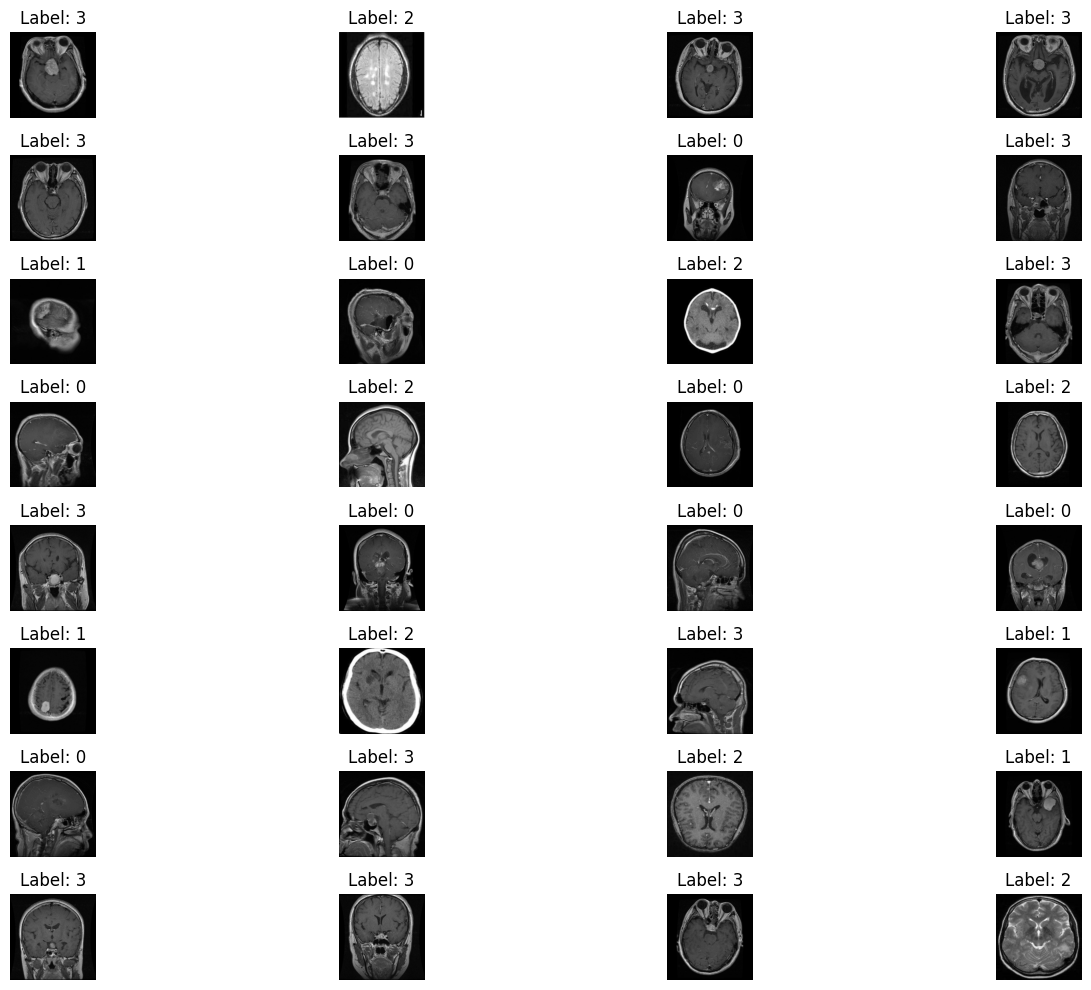

In [61]:
# transform the images to ensure equal size and tensors
transform = transforms.Compose([
	transforms.Resize((512, 512)),
	transforms.ToTensor(),
	transforms.Grayscale()	
])

train_dataset = BrainTumorDataset(train_df, train_dir, transform=transform)
test_dataset = BrainTumorDataset(test_df, test_dir, transform=transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Display the images in a grid from one batch in the DataLoader
for imgs, labels in train_loader:
    show_image_grid(imgs, labels, rows = batch_size//4, cols = 4)
    break  

In [18]:
class VisionTransformer(L.LightningModule):
    def __init__(self, 
                 embedding_dim=64, 
                 patch_size=32, 
                 num_layers=4, 
                 n_heads=8, 
                 dim_feedforward=64):
        super().__init__()
        self.embedding = nn.Conv2d(
            1, embedding_dim, kernel_size=patch_size, stride=patch_size
        )

        # class token for classification
        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        # positional embedding
        self.positional_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))
        # transformer encoder layer
        self.encoder = nn.TransformerEncoder( # we can add a norm between each encoder layer here
            nn.TransformerEncoderLayer( 
                d_model=embedding_dim, nhead=n_heads, dim_feedforward=dim_feedforward
            ),
            num_layers=num_layers,
            enable_nested_tensor=False,
        )
        
		# linear layer for classification
        # TODO

    def forward(self, x):
        x = self.embedding(x)
        # TODO
        return x


# test with random image
model = VisionTransformer(embedding_dim=8)
imgs, labels = next(iter(train_loader))
output = model(imgs[0])
output = output.flatten(start_dim=1)
print(output.shape)

torch.Size([8, 256])


# Pre trained model

In [ ]:
transform = transforms.Compose([
	transforms.Grayscale(num_output_channels=3),	# convert to 3 channels
	transforms.Resize((224, 224)), 					# resize to 224x224
	transforms.ToTensor(),
])

train_dataset = BrainTumorDataset(train_df, train_dir, transform=transform)
test_dataset = BrainTumorDataset(test_df, test_dir, transform=transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load pre-trained model
model = vit_b_16(weights='IMAGENET1K_V1')

# Modify for 4 classes
model.heads = nn.Linear(model.hidden_dim, 4) 

model = model.to(device)
summary(model)


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # Iterate over the training data
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for current batch
        running_loss += loss.item() * inputs.size(0)

    # Calculate and print average loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print("Training complete.")


Training Epoch 1/3:   1%|          | 1/179 [00:39<1:56:08, 39.15s/it]


KeyboardInterrupt: 